In [93]:
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt
import math
import scipy  
%matplotlib inline

In [95]:
X_train, y_train = load_svmlight_file("./data/a9a")
X_val, y_val = load_svmlight_file("./data/a9a.t")

X_train = scipy.sparse.hstack((scipy.sparse.csr_matrix(np.ones((len(y_train),1))),X_train))
X_val = scipy.sparse.hstack((scipy.sparse.csr_matrix(np.ones((len(y_val),1))),X_val))

X_val = scipy.sparse.hstack((X_val, scipy.sparse.csr_matrix(np.zeros((len(y_val),1)))))

X_train = X_train.tocsr()
X_val = X_val.tocsr()

y_train = y_train.reshape((len(y_train),1))
y_val = y_val.reshape((len(y_val),1))

In [96]:
def hinge_loss(w,X,Y,):
    N,D   = np.shape(X)  
    zero = np.zeros((N,1))
    score = X.dot(w)
    margin = 1 - Y * score
    return np.max([zero,margin],axis=0)

In [97]:
def forward(X,Y,w,reg=0.0):
    N,D = np.shape(X)  
    loss = hinge_loss(w,X,Y)
    reg_loss = 1.0/2 * reg * w.transpose().dot(w)
    loss = 1.0/N * loss.sum()  + reg_loss
    return loss[0][0]

In [98]:
def gradient(X,Y,w,reg=0.0):
    N,D = np.shape(X)  
    loss = hinge_loss(w,X,Y)
    counts = np.zeros((N,1))
#     区分
    counts[np.nonzero(loss)] = 1
    dW = - 1.0/float(N) * X.transpose().dot(Y * counts).sum(axis=1).reshape((D,1))
    dW += reg * w
    return dW

In [99]:
def SGD(X,Y,w,reg,lr):
    return w -lr * gradient(X,Y,w,reg=reg)

In [100]:
def NAG(X,Y,w,reg,lr,alpha,v_curr):
    v = alpha * v_curr + lr * gradient(X,Y,w - alpha * v_curr,reg=reg)
    return w - v,v

In [101]:
def Adadelta(X,Y,w,reg,last_E_g2,last_E_delta2,gamma,epsilon = 1e-8):
    g = gradient(X,Y,w,reg=reg)
    
    E_g2 = gamma * last_E_g2 + (1-gamma) * (g*g)
    
    RMS_g = np.sqrt(E_g2)+epsilon
    
    RMS_delta_curr = np.sqrt(last_E_delta2)+epsilon
    
    delta = RMS_delta_curr / RMS_g * g
    
    E_delta2  = gamma * last_E_delta2 + (1-gamma) * (delta*delta)
    return w - delta,E_g2,E_delta2 

In [102]:
def RMSprop(X,Y,w,reg,lr,last_E_g2,gamma,epsilon = 1e-8):
    g = gradient(X,Y,w,reg=reg)
    
    E_g2 = gamma * last_E_g2 + (1-gamma) * (g*g)
    
    RMS_g = np.sqrt(E_g2)+epsilon
    
    delta = lr / RMS_g * g
    
    return w - delta,E_g2

In [103]:
def Adam(X,Y,w,reg,lr,last_v,last_s,beta1,beta2,iteration,epsilon = 1e-8):
    g = gradient(X,Y,w,reg=reg)
    
    v = beta1 * last_v + (1-beta1) * g
    s = beta2 * last_s + (1-beta2) * (g*g)
    
    v_hat = v/(1-beta1**iteration)
    s_hat = s/(1-beta2**iteration)
    
    delta = lr * (v_hat/ (np.sqrt(s_hat)+epsilon))
    return w - delta,v,s

In [104]:
def predict(w,X,threshold=0.5):
    raw = X.dot(w)
    raw[raw<=threshold] = -1
    raw[raw>threshold] = 1
    return raw

In [105]:
def accuracy(w,X,Y,threshold=0.5):
    num_records,num_features  = np.shape(X)  
    P = predict(w,X,threshold)
    
    is_right = P * Y
    is_right[is_right < 0] = 0
    
    return 1.0/num_records * np.count_nonzero(is_right)

In [106]:
reg = 0.1
lr = 0.05


threshold=0.5
epoch = 5
batch_size = 256

N,D = np.shape(X_train)
w = np.random.normal(size=(D,1))

# SGD
train_loss_SGD = []
val_loss_SGD = []
train_accuracy_SGD = []
val_accuracy_SGD = []

# NAG
train_loss_NAG = []
val_loss_NAG = []
train_accuracy_NAG = []
val_accuracy_NAG = []
NAG_w = w
alpha = 0.9
v_curr = np.zeros((D,1))

# Adadelta
train_loss_Adadelta = []
val_loss_Adadelta = []
train_accuracy_Adadelta = []
val_accuracy_Adadelta = []
Adadelta_w = w
Adadelta_gamma = 0.95
epsilon = 1e-8
Adadelta_E_delta2_init=1e-4,
Adadelta_g2 = np.zeros((D,1))
Adadelta_E_delta2 = np.zeros((D,1)) + Adadelta_E_delta2_init

# RMSprop
train_loss_RMSprop = []
val_loss_RMSprop = []
train_accuracy_RMSprop = []
val_accuracy_RMSprop = []
RMSprop_w = w
RMSprop_gamma = 0.8
epsilon = 1e-8
RMSprop_g2 = np.zeros((D,1))

# Adam
train_loss_Adam = []
val_loss_Adam = []
train_accuracy_Adam = []
val_accuracy_Adam = []
Adam_w = w
Adam_beta1 = 0.9
Adam_beta2 = 0.99
Adam_epsilon = 1e-8
Adam_v = np.zeros((D,1))
Adam_s = np.zeros((D,1))

iteration = 1

In [107]:
for counter in range(epoch):
    #     shuffle the dataset
    X_train,X_t,y_train,y_t = train_test_split(X_train,y_train,test_size=0) 

    starts = [i*batch_size for i in range(math.ceil(N/batch_size))]
    ends = [i*batch_size for i in range(1,math.ceil(N/batch_size))]
    ends.append(N)
    for start, end in zip(starts, ends):
        
        # SGD
        train_loss_SGD.append(forward(X_train[start:end,:],y_train[start:end,:],w,reg))
        val_loss_SGD.append(forward(X_val,y_val,w,reg))
        
        train_accuracy_SGD.append(accuracy(w,X_train[start:end,:],y_train[start:end,:],threshold))
        val_accuracy_SGD.append(accuracy(w,X_val,y_val,threshold))
        
        w = SGD(X_train[start:end,:],y_train[start:end,:],w,reg=reg,lr=lr)

        # NAG
        train_loss_NAG.append(forward(X_train[start:end,:],y_train[start:end,:],NAG_w,reg))
        val_loss_NAG.append(forward(X_val,y_val,NAG_w,reg))
        
        train_accuracy_NAG.append(accuracy(NAG_w,X_train[start:end,:],y_train[start:end,:],threshold))
        val_accuracy_NAG.append(accuracy(NAG_w,X_val,y_val,threshold))
        
        NAG_w,v_curr = NAG(X_train[start:end,:],y_train[start:end,:],NAG_w,reg,lr,alpha,v_curr)
        
        # Adadelta 
        train_loss_Adadelta.append(forward(X_train[start:end,:],y_train[start:end,:],Adadelta_w,reg))
        val_loss_Adadelta.append(forward(X_val,y_val,Adadelta_w,reg))
        
        train_accuracy_Adadelta.append(accuracy(Adadelta_w,X_train[start:end,:],y_train[start:end,:],threshold))
        val_accuracy_Adadelta.append(accuracy(Adadelta_w,X_val,y_val,threshold))
        
        Adadelta_w,Adadelta_g2,Adadelta_E_delta2 = Adadelta(X_train[start:end,:],y_train[start:end,:],\
                                                            Adadelta_w,reg,Adadelta_g2,Adadelta_E_delta2,\
                                                            Adadelta_gamma,epsilon)
        
        # RMSprop
        train_loss_RMSprop.append(forward(X_train[start:end,:],y_train[start:end,:],RMSprop_w,reg))
        val_loss_RMSprop.append(forward(X_val,y_val,RMSprop_w,reg))
        
        train_accuracy_RMSprop.append(accuracy(RMSprop_w,X_train[start:end,:],y_train[start:end,:],threshold))
        val_accuracy_RMSprop.append(accuracy(RMSprop_w,X_val,y_val,threshold))
        
        RMSprop_w,RMSprop_g2 = RMSprop(X_train[start:end,:],y_train[start:end,:],\
                                                              RMSprop_w,reg,lr,RMSprop_g2,RMSprop_gamma,epsilon)

        # Adam
        train_loss_Adam.append(forward(X_train[start:end,:],y_train[start:end,:],Adam_w,reg))
        val_loss_Adam.append(forward(X_val,y_val,Adam_w,reg))
        
        train_accuracy_Adam.append(accuracy(Adam_w,X_train[start:end,:],y_train[start:end,:],threshold))
        val_accuracy_Adam.append(accuracy(Adam_w,X_val,y_val,threshold))
        
        Adam_w,Adam_v,Adam_s = Adam(X_train[start:end,:],y_train[start:end,:],Adam_w,reg,lr,Adam_v,Adam_s,\
                                    Adam_beta1,Adam_beta2,iteration,Adam_epsilon)
        
        iteration += 1 

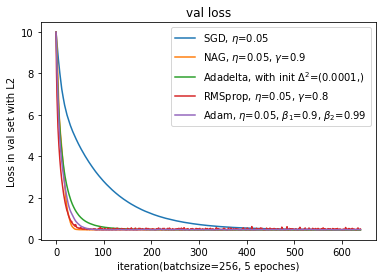

In [108]:
fig, ax = plt.subplots()
test_loss_line = ax.plot(range(iteration-1),val_loss_SGD,label=r'SGD, $\eta$='+str(lr))
NAG_test_loss_line = ax.plot(range(iteration-1),val_loss_NAG,\
                             label=r'NAG, $\eta$='+str(lr)+r', $\gamma$='+str(alpha))
Adadelta_test_loss_line = ax.plot(range(iteration-1),val_loss_Adadelta,\
                                  label=r'Adadelta, with init $\Delta^2$='+str(Adadelta_E_delta2_init))
RMSprop_test_loss_line = ax.plot(range(iteration-1),val_loss_RMSprop,\
                                 label=r'RMSprop, $\eta$='+str(lr)+r', $\gamma$='+str(RMSprop_gamma))
Adam_test_loss_line = ax.plot(range(iteration-1),val_loss_Adam,\
                              label=r'Adam, $\eta$='+str(lr)+r', $\beta_1$='+\
                              str(Adam_beta1)+r', $\beta_2$='+str(Adam_beta2))
plt.legend()
plt.title('val loss')
ax.set(xlabel='iteration(batchsize=256, 5 epoches)', ylabel='Loss in val set with L2')
plt.show()

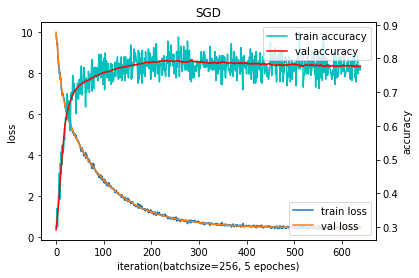

In [109]:
fig, ax = plt.subplots()
ax_e = ax.twinx()
train_loss_line = ax.plot(range(len(train_accuracy_SGD)),train_loss_SGD,label='train loss')
test_loss_line = ax.plot(range(len(train_accuracy_SGD)),val_loss_SGD,label='val loss')
train_accuracy_line = ax_e.plot(range(len(train_accuracy_SGD)),train_accuracy_SGD,'c',label='train accuracy')
test_accuracy_line = ax_e.plot(range(len(train_accuracy_SGD)),val_accuracy_SGD,'r',label='val accuracy')

ax.set(xlabel='iteration(batchsize=256, 5 epoches)', ylabel='loss')
ax_e.set_ylabel('accuracy')
plt.title('SGD')
ax.legend(loc=4)
ax_e.legend(loc=1)
plt.show()

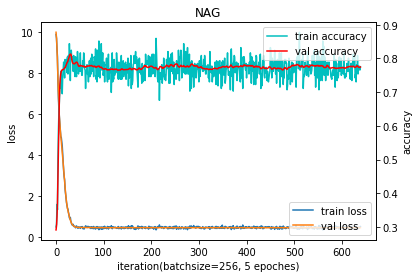

In [110]:
fig, ax = plt.subplots()
ax_e = ax.twinx()
train_loss_line = ax.plot(range(len(train_accuracy_NAG)),train_loss_NAG,label='train loss')
test_loss_line = ax.plot(range(len(train_accuracy_NAG)),val_loss_NAG,label='val loss')
train_accuracy_line = ax_e.plot(range(len(train_accuracy_NAG)),train_accuracy_NAG,'c',label='train accuracy')
test_accuracy_line = ax_e.plot(range(len(train_accuracy_NAG)),val_accuracy_NAG,'r',label='val accuracy')

ax.set(xlabel='iteration(batchsize=256, 5 epoches)', ylabel='loss')
ax_e.set_ylabel('accuracy')
plt.title('NAG')
ax.legend(loc=4)
ax_e.legend(loc=1)
plt.show()

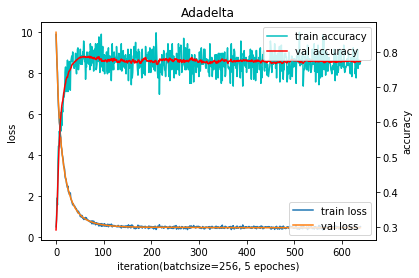

In [111]:
fig, ax = plt.subplots()
ax_e = ax.twinx()
train_loss_line = ax.plot(range(len(train_accuracy_Adadelta)),train_loss_Adadelta,label='train loss')
test_loss_line = ax.plot(range(len(train_accuracy_Adadelta)),val_loss_Adadelta,label='val loss')
train_accuracy_line = ax_e.plot(range(len(train_accuracy_Adadelta)),train_accuracy_Adadelta,'c',label='train accuracy')
test_accuracy_line = ax_e.plot(range(len(train_accuracy_Adadelta)),val_accuracy_Adadelta,'r',label='val accuracy')

ax.set(xlabel='iteration(batchsize=256, 5 epoches)', ylabel='loss')
ax_e.set_ylabel('accuracy')
plt.title('Adadelta')
ax.legend(loc=4)
ax_e.legend(loc=1)
plt.show()

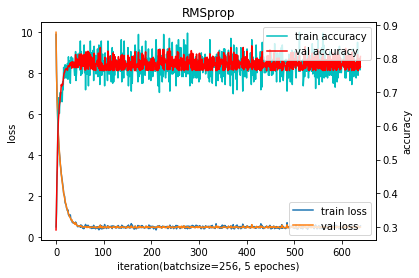

In [112]:
fig, ax = plt.subplots()
ax_e = ax.twinx()
train_loss_line = ax.plot(range(len(train_accuracy_RMSprop)),train_loss_RMSprop,label='train loss')
test_loss_line = ax.plot(range(len(train_accuracy_RMSprop)),val_loss_RMSprop,label='val loss')
train_accuracy_line = ax_e.plot(range(len(train_accuracy_RMSprop)),train_accuracy_RMSprop,'c',label='train accuracy')
test_accuracy_line = ax_e.plot(range(len(train_accuracy_RMSprop)),val_accuracy_RMSprop,'r',label='val accuracy')

ax.set(xlabel='iteration(batchsize=256, 5 epoches)', ylabel='loss')
ax_e.set_ylabel('accuracy')
plt.title('RMSprop')
ax.legend(loc=4)
ax_e.legend(loc=1)
plt.show()

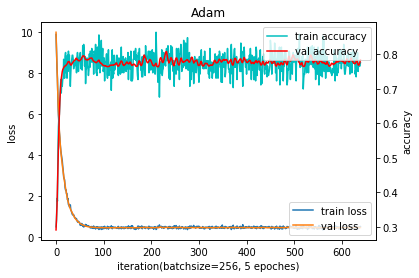

In [113]:
fig, ax = plt.subplots()
ax_e = ax.twinx()
train_loss_line = ax.plot(range(len(train_accuracy_Adam)),train_loss_Adam,label='train loss')
test_loss_line = ax.plot(range(len(train_accuracy_Adam)),val_loss_Adam,label='val loss')
train_accuracy_line = ax_e.plot(range(len(train_accuracy_Adam)),train_accuracy_Adam,'c',label='train accuracy')
test_accuracy_line = ax_e.plot(range(len(train_accuracy_Adam)),val_accuracy_Adam,'r',label='val accuracy')

ax.set(xlabel='iteration(batchsize=256, 5 epoches)', ylabel='loss')
ax_e.set_ylabel('accuracy')
plt.title('Adam')
ax.legend(loc=4)
ax_e.legend(loc=1)
plt.show()